### Here i will do another basic visualization on Geospatial data. The data that i am using here is still the same from which i used before.

In [1]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point,Polygon,LineString
from folium.plugins import FastMarkerCluster
from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup
from keplergl import KeplerGl
import branca
import branca.colormap as cm

In [2]:
df = gpd.read_file('/Users/danielbeltsazar/Work/ZebraX/Coding/Geospatial/clean_result.csv')
df.head()

,datetime,txid,vessel_name,lat,lon,fleet_work_center,route_name,network_no,position,route_polygon,is_outside_route,deviation_in_meter,geometry
0,2020-08-08 14:15:00.000,T818,TB ENTEBE MEGASTAR 79,-1.7195,116.6212,TBMS79,TMCT-ADANGBAY,174000021674,POINT (116.6212 -1.7195),POLYGON ((116.16248591680016 -1.80794871782329...,1,76.17405892,None
1,2020-08-08 16:30:00.000,T818,TB ENTEBE MEGASTAR 79,-1.7194,116.6208,TBMS79,TMCT-ADANGBAY,174000021674,POINT (116.6208 -1.7194),POLYGON ((116.16248591680016 -1.80794871782329...,1,62.87094379,None
2,2020-08-08 14:00:00.000,T818,TB ENTEBE MEGASTAR 79,-1.7195,116.6212,TBMS79,TMCT-ADANGBAY,174000021674,POINT (116.6212 -1.7195),POLYGON ((116.16248591680016 -1.80794871782329...,1,76.17405892,None
3,2020-08-08 16:15:00.000,T818,TB ENTEBE MEGASTAR 79,-1.7195,116.6208,TBMS79,TMCT-ADANGBAY,174000021674,POINT (116.6208 -1.7195),POLYGON ((116.16248591680016 -1.80794871782329...,1,73.91421159,None
4,2020-08-08 13:45:00.000,T818,TB ENTEBE MEGASTAR 79,-1.7208,116.6206,TBMS79,TMCT-ADANGBAY,174000021674,POINT (116.6206 -1.7208),POLYGON ((116.16248591680016 -1.80794871782329...,1,216.34677472,None


In [3]:
df['lat']=df['lat'].astype("float")
df['lon']=df['lon'].astype("float")
df['deviation_in_meter']=df['deviation_in_meter'].astype("float")
df['network_no']=df['network_no'].astype('int')
df['is_outside_route']=df['is_outside_route'].astype('int')
df['datetime']=pd.to_datetime(df['datetime'])

In [4]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 541639 entries, 0 to 541638
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   datetime            541639 non-null  datetime64[ns]
 1   txid                541639 non-null  object        
 2   vessel_name         541639 non-null  object        
 3   lat                 541639 non-null  float64       
 4   lon                 541639 non-null  float64       
 5   fleet_work_center   541639 non-null  object        
 6   route_name          541639 non-null  object        
 7   network_no          541639 non-null  int64         
 8   position            541639 non-null  object        
 9   route_polygon       541639 non-null  object        
 10  is_outside_route    541639 non-null  int64         
 11  deviation_in_meter  541639 non-null  float64       
 12  geometry            0 non-null       geometry      
dtypes: datetime64[ns](1),

In [5]:
df['route_name'].value_counts()

TMCT-ADANGBAY         488552
ASAM-ASAM-REMBANG      24112
ASAM-ASAM-PAITON       18923
TARAHAN-LABUAN          5406
TARAHAN-PLTULONTAR      4646
Name: route_name, dtype: int64

## Plotting Function For Each Route

### Plotting Function

In [6]:
def plot_map(df,routename):
    df1 = df[df['route_name']==routename]
    df1 = df1.drop(['geometry'],axis=1)
    
    df1['position'] = gpd.GeoSeries.from_wkt(df1['position'])
    df1 = gpd.GeoDataFrame(df1, geometry='position')
    df1['route_polygon'] = gpd.GeoSeries.from_wkt(df1['route_polygon'])
    df1 = gpd.GeoDataFrame(df1, geometry='route_polygon')
    
    df1.crs = "epsg:4326"
    df1=df1.to_crs("EPSG:4326")
    
    colormap = cm.LinearColormap(colors=['yellow','red'], index=[0,15000],vmin=0,vmax=15000)
    dev = list(df1.deviation_in_meter)
    
    #x_start = (df1['lat'].max() + df1['lat'].min()) / 2
    #y_start = (df1['lon'].max() + df1['lon'].min()) / 2
    x_start = (df1['lat'].mean())
    y_start = (df1['lon'].mean())
    start_coord = (x_start, y_start)

    maps = folium.Map(location = start_coord,zoom_start = 8)
    geo_df1_list = [[point.xy[1][0], point.xy[0][0]] for point in df1.position]
    for coordinates,p in zip(geo_df1_list,dev):
        folium.CircleMarker(location = coordinates,radius=2,color=colormap(p)).add_to(maps)
    maps.add_child(colormap)
    folium.GeoJson(data=df1["route_polygon"]).add_to(maps)
    #maps.save(" maps {}.html ".format(routename))
    return maps

### Plotting Function to combine 2 plots

In [7]:
def plot_map_add(df,routename,maps):
    df1 = df[df['route_name']==routename]
    df1 = df1.drop(['geometry'],axis=1)
    
    df1['position'] = gpd.GeoSeries.from_wkt(df1['position'])
    df1 = gpd.GeoDataFrame(df1, geometry='position')
    df1['route_polygon'] = gpd.GeoSeries.from_wkt(df1['route_polygon'])
    df1 = gpd.GeoDataFrame(df1, geometry='route_polygon')
    
    df1.crs = "epsg:4326"
    df1=df1.to_crs("EPSG:4326")
    
    colormap = cm.LinearColormap(colors=['yellow','red'], index=[0,15000],vmin=0,vmax=15000)
    dev = list(df1.deviation_in_meter)
    
    #x_start = (df1['lat'].max() + df1['lat'].min()) / 2
    #y_start = (df1['lon'].max() + df1['lon'].min()) / 2
    #x_start = (df1['lat'].mean())
    #y_start = (df1['lon'].mean())
    #start_coord = (x_start, y_start)

    #maps = folium.Map(location = start_coord,zoom_start = 8)
    geo_df1_list = [[point.xy[1][0], point.xy[0][0]] for point in df1.position]
    for coordinates,p in zip(geo_df1_list,dev):
        folium.CircleMarker(location = coordinates,radius=2,color=colormap(p)).add_to(maps)
    #maps.add_child(colormap)
    folium.GeoJson(data=df1["route_polygon"]).add_to(maps)
    #maps.save(" maps {}.html ".format(routename))
    display(maps)

### First we create a plot consisting of one of the routes and the vessels GPS tracking positions along the route

In [8]:
map1 = plot_map(df,'TARAHAN-PLTULONTAR')

### Then we can see the map below. Once again, i only inserted the snapshot picture of the map that is generated by folium. It is because the python notebook will be too large for github to be rendered. The actual map is interactive as we can zoom in/out and slide the map.

In [10]:
#map1

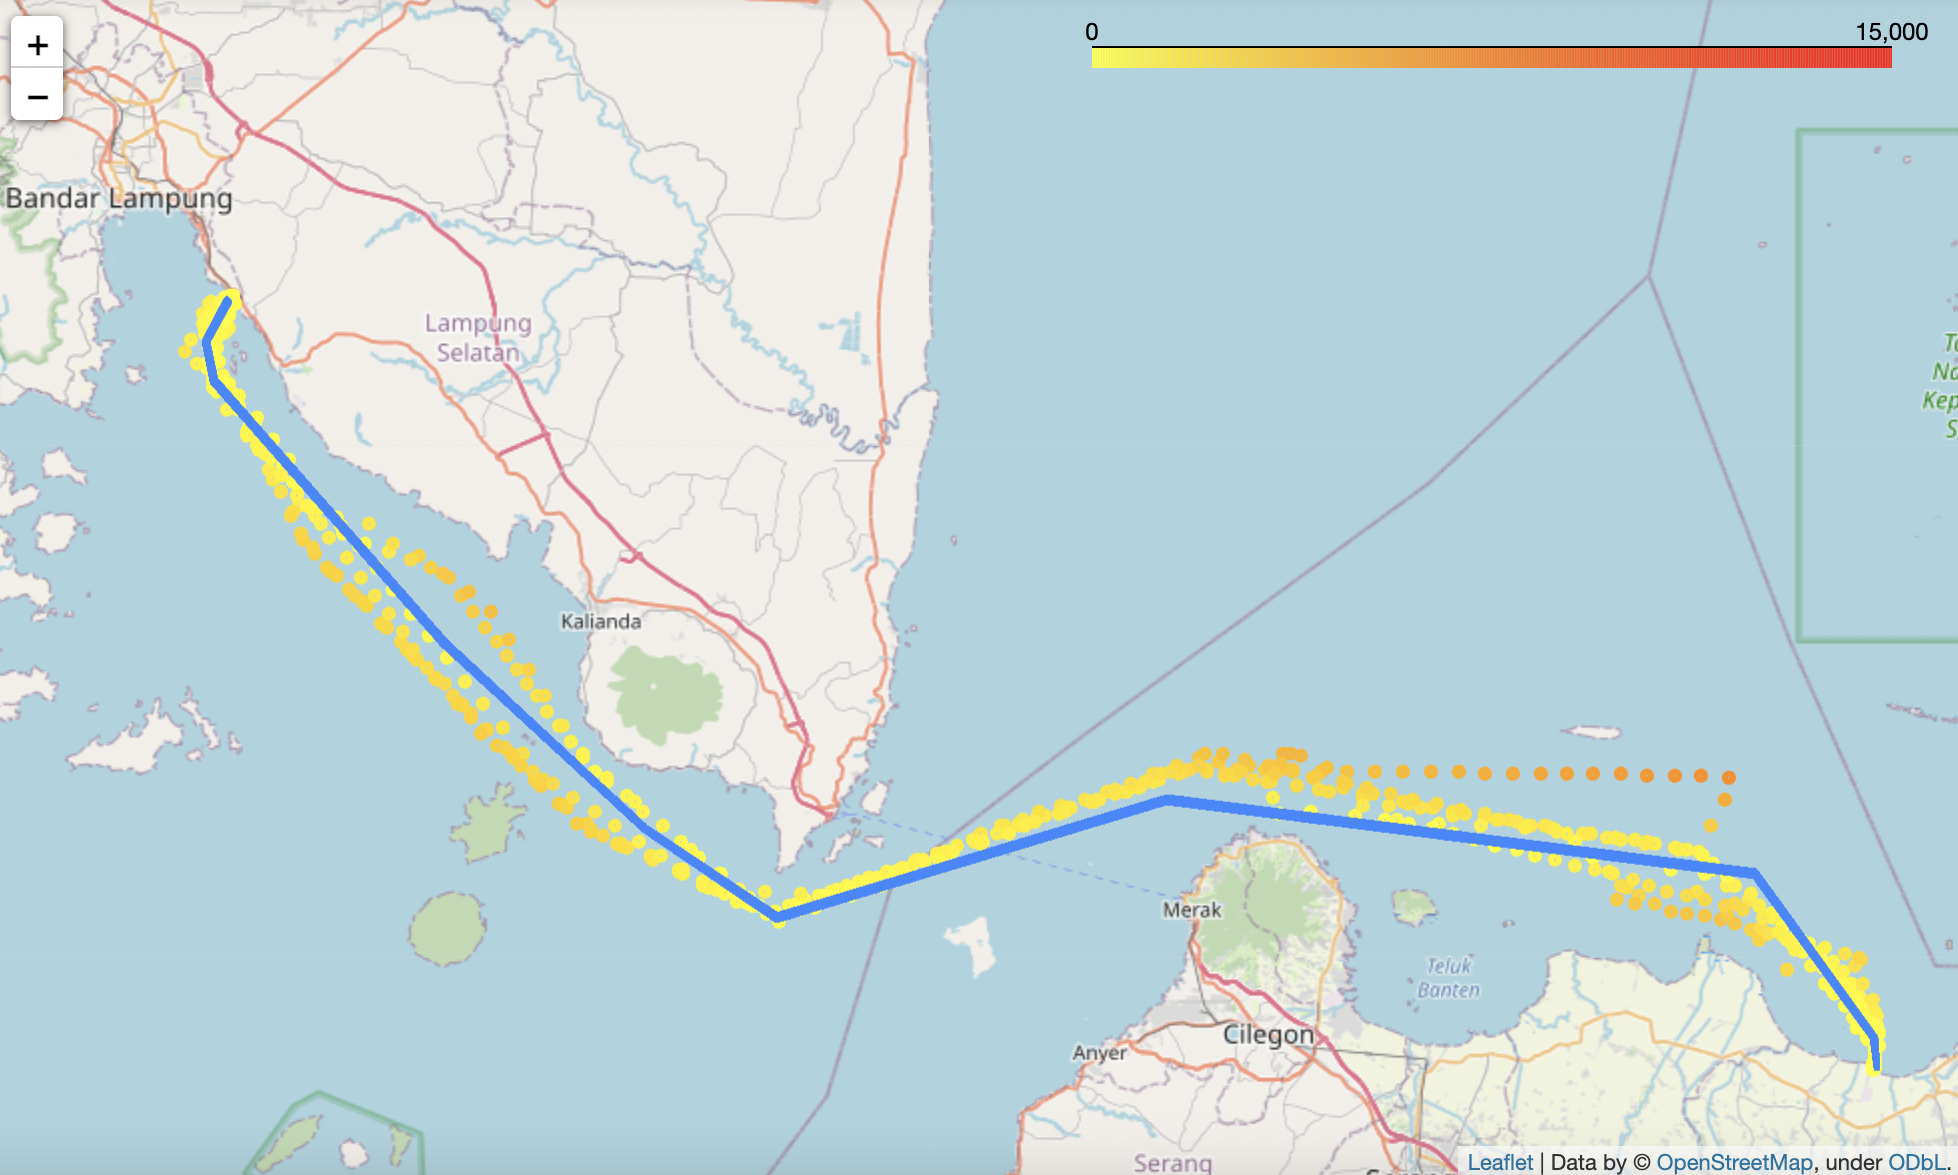

### Than we combine the plot before (map1) with the plot of the new route

In [12]:
#plot_map_add(df,'TARAHAN-LABUAN',map1)

### We can see here 2 routes of the vessels in one map. I didn't rendered both routes in one go because it will make heavier work load.

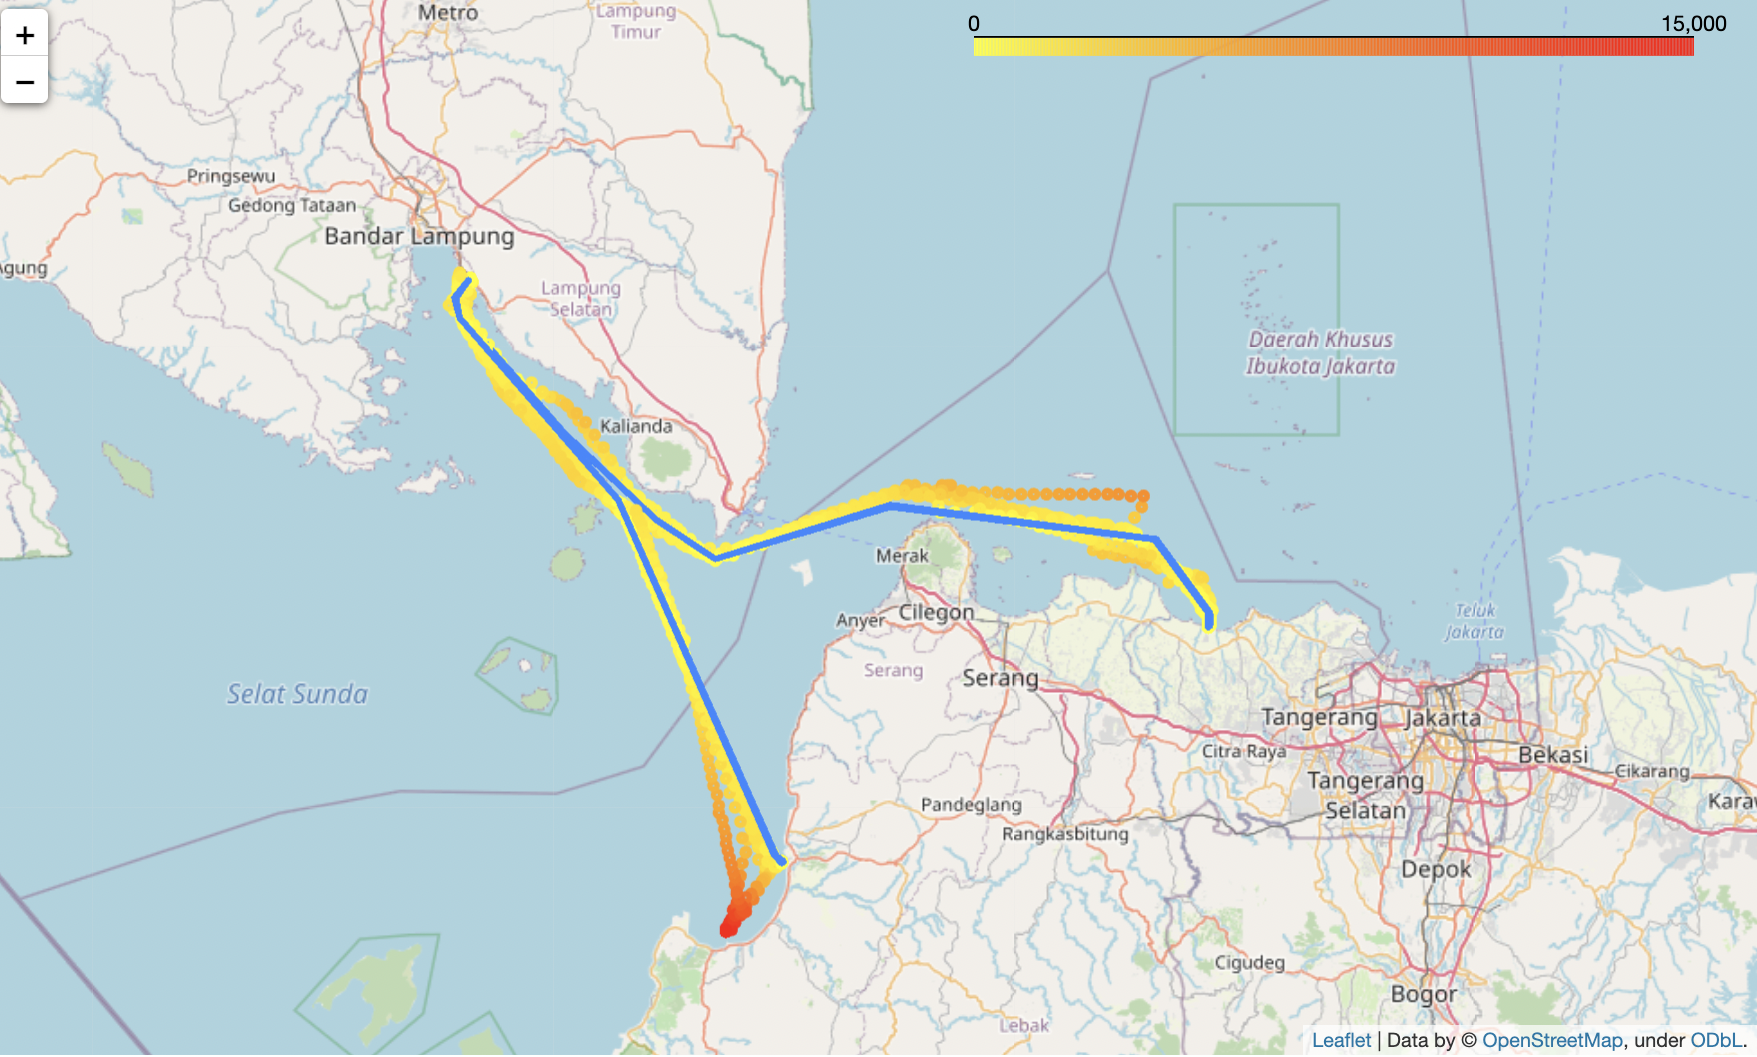